# 8.2. Text Classification

In this notebook, we will learn how to perform a simple text classification using `torchtext`. This is similar to the image classification problem, in which the network's task is to assign a label to the given image but in text.

Text data is more like an audio signal in terms of its dimensionality (i.e., 1D). They are both a sequence of numbers:
* In an audio signal the sequence is temporal.
* In the  text data the sequence is positional (i.e., the position of words in a sentence).


## 0. Preparation

In order to run this notebook, we need to perform some preparations.

We use datasets from `torchtext` that require `portalocker` package.
In Google Colab you can install it by uncommenting and executing the next 
code cell.

In [1]:
# !pip install portalocker>=2.0.0

### Packages

Let's start with all the necessary packages to implement this tutorial.

 * [numpy](https://numpy.org/) is the main package for scientific computing with Python. It's often imported with the `np` shortcut.
 * [termcolor](https://github.com/termcolor/termcolor) is an ANSI colour formatting for output in the terminal.
 * [matplotlib](https://matplotlib.org/) is a library to plot graphs in Python.
 * [os](https://docs.python.org/3/library/os.html) provides a portable way of using operating system-dependent functionality, e.g., modifying files/folders.
 * [torch](https://pytorch.org/docs/stable/index.html) is a deep learning framework that allows us to define networks, handle datasets, optimise a loss function, etc.

In [2]:
import numpy as np
import os

from matplotlib import pyplot as plt
from termcolor import colored

import torch
import torch.nn as nn
import torchtext

### Device
Choosing CPU or GPU based on the availability of the hardware.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Selected device:', colored(device, 'red'))

Selected device: cuda


## 1. Dataset

The [torchtext.dataset](https://pytorch.org/text/stable/datasets.html) offers easy access to several text datasets. In this tutorial, we use the [AG’s News Corpus dataset](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) that contains 120000 samples for training and 7600 for testing. Each piece of news corresponds to one of the following four categories:
1. World
2. Sport
3. Business
4. Sci/Tec

To load our dataset:
* We use the `torchtext.datasets.AG_NEWS` module.
* The first time you execute the next cell, it downloads the dataset and extracts its content in the `./data/` directory.
* `torchtext` datasets are implemented in an iterable-style unlike `torchvision`/`torchaudio` which are map-style. So we call the `to_map_style_dataset` to convert the dataset into map-style. This way we can reuse a large part of our training/testing pipeline from image/audio classification notebooks.

In [4]:
train_db = torchtext.datasets.AG_NEWS(root='./data/', split="train")
test_db = torchtext.datasets.AG_NEWS(root='./data/', split="test")

train_db = torchtext.data.functional.to_map_style_dataset(train_db)
test_db = torchtext.data.functional.to_map_style_dataset(test_db)

We create a `dict` to convert label numbers to human-readable text. Please note that in
Python indexing starts from 0 therefore the labels are in the range of 0-3 (the raw data
in the downloaded `CSV` files is in the range of 1-4)-

In [5]:
ag_news_labels = {
    0: "World", 
    1: "Sports", 
    2: "Business", 
    3: "Sci/Tec"
}

Let's get one sample from our dataset and print its content:

In [6]:
label_sample, text_sample = train_db.__getitem__(0)
print(label_sample, ag_news_labels[label_sample-1])
print(text_sample)

3 Business
Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


### Preprocessing

The news piece in the raw data is in the form of a string. We should process this
into an array of numbers before passing it to a network. This consists of the following
steps:
1. Splitting the text (string sentence) into the smallest units (tokens).
2. Creating a dictionary (i.e., look up table) of all words (tokens) in our dataset.
3. We convert the raw text into indices of this dictionary.

### Tokeniser

We simply use the `get_tokenizer` function to split the text into the smallest units (tokens).
Our dataset is in English therefore we pass the `basic_english` which defines how to tokenise 
a string (e.g., by words, spaces and punctuations).

In [7]:
tokeniser = torchtext.data.utils.get_tokenizer("basic_english")

Let's use the tokenise with one sample from our dataset to inspect its output.

In [8]:
tokned_string = tokeniser(text_sample)
print('The string consists of %d tokens:\n%s' % (len(tokned_string), tokned_string))

The string consists of 29 tokens:
['wall', 'st', '.', 'bears', 'claw', 'back', 'into', 'the', 'black', '(', 'reuters', ')', 'reuters', '-', 'short-sellers', ',', 'wall', 'street', "'", 's', 'dwindling\\band', 'of', 'ultra-cynics', ',', 'are', 'seeing', 'green', 'again', '.']


### Vocabulary

We use the `torchtext.vocab.build_vocab_from_iterator` to create the dictionary for our dataset:
* The first argument is an iterator. We create the `tokens_iter` function which simply iterates over the entire dataset and `yield` the tokenised text.
* In the second argument we can pass a list of special characters. In this case, we only pass `"<unk>"` (out-of-vocabulary or unknown word).
* Finally, by calling the `set_default_index` we specify that if a word (token) in a sentence doesn't exist in the vocabulary, assign it to the `"<unk>"` token.

In [9]:
def tokens_iter(dataset):
    for i in range(dataset.__len__()):
        _label, text = dataset.__getitem__(i)
        yield tokeniser(text)

db_vocab = torchtext.vocab.build_vocab_from_iterator(tokens_iter(train_db), specials=["<unk>"])
db_vocab.set_default_index(db_vocab["<unk>"])

Let's have a look at the number of words in our dictrionary.

In [10]:
print('The number of words in the dictrionary: %d' % len(db_vocab))

The number of words in the dictrionary: 95811


Let's print the first ten words (tokens) in our dataset:

In [11]:
ten_tokens = db_vocab.lookup_tokens(np.arange(10))
for tind, token in enumerate(ten_tokens):
    print('%d: %s' % (tind, token))

0: <unk>
1: .
2: the
3: ,
4: to
5: a
6: of
7: in
8: and
9: s


### Raw-text to dictionary-index

We create `rawtex2dicind` which is a small anonymous function (`lambda`) that converts the raw-text into dictionary-indices.

In [12]:
rawtex2dicind = lambda x: db_vocab(tokeniser(x))

Let's call the dictrionary with a small sentence to check what is its output.

In [13]:
rawtex2dicind('This is a jupyter notebook.')

[52, 21, 5, 0, 1928, 1]

The output is the index of tokens (words) in our dictionary.
We already knew the index of:
* "a": **5**
* "jupyter": **0** because it's unknown
* ".": **1**

Note, that the dictrionary is case insensitive. There "a" and "A" result in the same index.

### Dataloaders

The length of sentences differs for each sample. This would cause an issue in creating the batch data (i.e., several texts). To create a `tensor` variable, all elements must have the same size. To overcome this, we pad the texts (i.e., the output of `rawtex2dicind`) with zeros to equalise all audio samples in a batch. This is implemented as follows:
* We create "custom" batches by passing `collate_fn=collate_fn` to `torch.utils.data.DataLoader` (for more details check its [documentation](https://pytorch.org/docs/stable/data.html#working-with-collate-fn)).
* We implement the `collate_fn` that calls the `rawtex2dicind` function.
* We pass the texts to  `pad_sequence` which makes them of identical size.

In [14]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    # for item in batch:
    #     print(len(item))
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0)
    # print(batch.shape)
    return batch

def collate_fn(batch):
    texts, targets = [], []
    for label_b, text_b in batch:
        # we tokenise it, get the vocabulary index and convert it to tensor
        texts.append(torch.tensor(rawtex2dicind(text_b), dtype=torch.int64))
        targets.append(int(label_b) - 1)  # -1 to bring label to 0 (the raw data start from 1)
    texts = pad_sequence(texts)
    # print(targets)
    targets = torch.tensor(targets)
    return texts, targets

train_loader = torch.utils.data.DataLoader(
    train_db, batch_size=128, shuffle=True, collate_fn=collate_fn
)

test_loader = torch.utils.data.DataLoader(
    test_db, batch_size=32, shuffle=False, collate_fn=collate_fn
)

## 2. Network

We define our network in the class `TextClassificationNet`. It consists of two layers:
* `nn.EmbeddingBag` to compute features. An [EmbedingBag layer](https://pytorch.org/docs/stable/generated/torch.nn.EmbeddingBag.html) computes sums/means of "bags" of embeddings, without instantiating the intermediate embeddings. In our example, the number of embeddings
is the number of words in our vocabulary. When we pass a text to this layer, it uses the values corresponding
to the bags (indices) of those existing within the text.
* `nn.Linear`: standard classification layer.

Usually, more advanced transforms are applied to the text data, however, this is beyond the scope of this notebook and the text classification we want to solve here.

In [15]:
class TextClassificationNet(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationNet, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)

    def forward(self, text):
        embedded = self.embedding(text)
        return self.fc(embedded)

Let's make an instance of this model and print it's parameters.

In [16]:
num_classes = len(set([label for (label, text) in train_db]))
vocab_size = len(db_vocab)

In [17]:
emb_size = 64
model = TextClassificationNet(vocab_size, emb_size, num_classes).to(device)
print(model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_model_parameters = count_parameters(model)
print("Number of parameters: %s" % num_model_parameters)

TextClassificationNet(
  (embedding): EmbeddingBag(95811, 64, mode='mean')
  (fc): Linear(in_features=64, out_features=4, bias=True)
)
Number of parameters: 6132164


## 3. Train/test routines

The following routines are very similar (close to identical) to what we previously
saw in the image/audio classification problem we have seen previously.

In [18]:
def epoch_loop(model, dataloader, criterion, optimiser, log_frequency=5000):
    # usually the code for train/test has a large overlap.
    is_train = False if optimiser is None else True

    # model should be in train/eval model accordingly
    model.train() if is_train else model.eval()
    
    accuracies = []
    losses = []
    with torch.set_grad_enabled(is_train):
        for batch_ind, (text, target) in enumerate(dataloader):
            text = text.to(device)
            target = target.to(device)

            output = model(text)
            # computing the loss
            loss = criterion(output, target)
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            losses.extend([loss.item() for _ in range(text.size(0))])
            # computing the accuracy
            acc = (output.argmax(1) == target).sum() / text.size(0)
            accuracies.extend([acc.item() for _ in range(text.size(0))])

            if batch_ind % log_frequency == 0 and batch_ind > 0:
                print(
                    '%s batches [%.5d/%.5d] \tloss=%.4f\tacc=%0.2f' % (
                        'training' if is_train else 'testing', batch_ind,
                        len(dataloader), np.mean(losses), np.mean(accuracies)
                    )
                )

            if is_train:
                # compute gradient and do SGD step
                optimiser.zero_grad()
                loss.backward()
                optimiser.step()
    return accuracies, losses

Finally, we can train and test the network. We will train the network
for ten epochs. The network reached close to $80\%$ accuracy on the test set.

In [19]:
# Hyperparameters
initial_epoch = 0
epochs = 40
lr = 0.1

model = TextClassificationNet(vocab_size, emb_size, num_classes).to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)
optimiser = torch.optim.SGD(model.parameters(), lr=lr)

train_logs = {'acc': [], 'loss': []}
val_logs = {'acc': [], 'loss': []}
for epoch in range(initial_epoch, epochs):
    print('Epoch [%.2d]' % epoch)
    train_log = epoch_loop(model, train_loader, criterion, optimiser)
    
    val_log = epoch_loop(model, test_loader, criterion, None)
    
    print('Train     loss=%.4f     acc=%0.2f    Test     loss=%.4f     acc=%0.2f' % 
          (
              np.mean(train_log[1]), np.mean(train_log[0]),
              np.mean(val_log[1]), np.mean(val_log[0])
          ))
    train_logs['acc'].append(np.mean(train_log[0]))
    train_logs['loss'].append(np.mean(train_log[1]))
    val_logs['acc'].append(np.mean(val_log[0]))
    val_logs['loss'].append(np.mean(val_log[1]))

Epoch [00]
Train     loss=1.3597     acc=0.34    Test     loss=1.3173     acc=0.42
Epoch [01]
Train     loss=1.3134     acc=0.41    Test     loss=1.2706     acc=0.45
Epoch [02]
Train     loss=1.2780     acc=0.44    Test     loss=1.2402     acc=0.44
Epoch [03]
Train     loss=1.2481     acc=0.46    Test     loss=1.2043     acc=0.47
Epoch [04]
Train     loss=1.2197     acc=0.48    Test     loss=1.1740     acc=0.49
Epoch [05]
Train     loss=1.1905     acc=0.50    Test     loss=1.1460     acc=0.51
Epoch [06]
Train     loss=1.1622     acc=0.51    Test     loss=1.1112     acc=0.54
Epoch [07]
Train     loss=1.1351     acc=0.53    Test     loss=1.0866     acc=0.54
Epoch [08]
Train     loss=1.1076     acc=0.55    Test     loss=1.0517     acc=0.57
Epoch [09]
Train     loss=1.0792     acc=0.56    Test     loss=1.0229     acc=0.58
Epoch [10]
Train     loss=1.0525     acc=0.58    Test     loss=1.0028     acc=0.59
Epoch [11]
Train     loss=1.0278     acc=0.59    Test     loss=0.9819     acc=0.60
Epoc

### Training progress

Let's plot the evolution of loss and accuracy for both train and test sets.

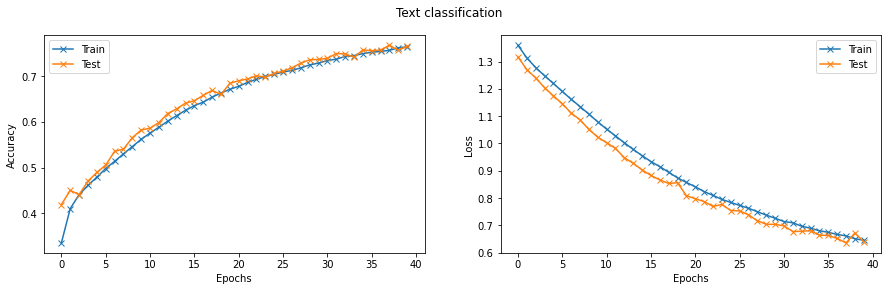

In [20]:
fig = plt.figure(figsize=(15, 4))
fig.suptitle('Text classification')
# accuraccy
ax = fig.add_subplot(1, 2, 1)
ax.plot(np.array(train_logs['acc']), '-x', label="Train")
ax.plot(np.array(val_logs['acc']), '-x', label="Test")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
# loss
ax = fig.add_subplot(1, 2, 2)
ax.plot(np.array(train_logs['loss']), '-x', label="Train")
ax.plot(np.array(val_logs['loss']), '-x', label="Test")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend()
plt.show()

### Prediction

Let's try our network with some news copy-pasted from Deutsche Welle.

In [21]:
def predict(text):
    with torch.no_grad():
        text = torch.tensor(db_vocab(tokeniser(text)))
        output = model(text.unsqueeze(dim=0).to(device))
        return output.argmax(dim=1).item()

In [25]:
ex_text_str = "Magnus Carlsen is now an ex-world champion after the Norwegian, 32, \
    abdicated the crown he had held with distinction for a decade. This week and next \
    the legend takes on the pair who met for his vacated title, in a new concept for \
    chess. The Tech Mahindra Global League (GCL) has six grandmaster teams, chosen by \
    franchise auction, competing in Dubai from June 21 to July 2."

print("This is a %s news" % ag_news_labels[predict(ex_text_str)])

ex_text_str = "The worldwide spice trade has a volume of some 130 billion dollars. \
    Demand for ever more exotic spices is rising. Estimates suggest that the spice \
    industry will grow by 37 percent this year over last year. We visit a spice \
    trader in Hamburg."

print("This is a %s news" % ag_news_labels[predict(ex_text_str)])

This is a Sports news
This is a Business news


## Excercises

Below is a list of exercises to practice what we have learnt in this notebook:
1. Visualise or print the values of the `EmbeddingBag` layer and compute its output for a simple text sentence.

## References

The following sources inspire the materials in this notebook:
1. [PyTorch torchtext tutorial](https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html)